In [49]:
from pynq import allocate
from pynq import Overlay
#import pynq.lib.dma

# Load the overlay
overlay = Overlay('./ip_repo/design_pipe_3.bit')
#overlay = Overlay('./ip_repo/design_pipe_2.bit')
#overlay = Overlay('./ip_repo/design_1_wrapper.bit')


# Load the FIR DMA
overlay.ip_dict
dma = overlay.axi_dma_0

#pipe 2
#registers = overlay.GrayScale_Accel_pipe_0

#pipe 3
registers = overlay.GrayScale_Accel_pipe_1
registers.read(0x0)

0

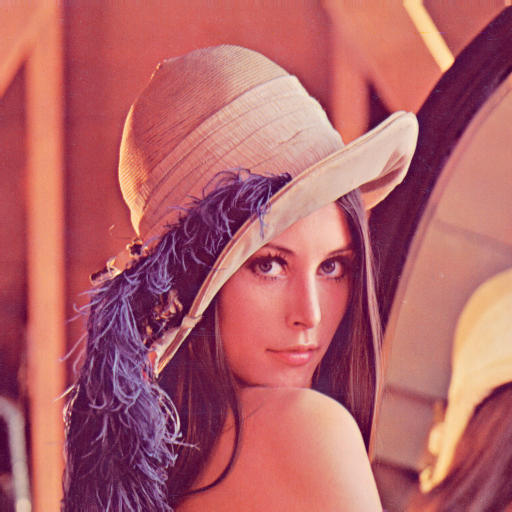

In [50]:
from PIL import Image

arquivo = Image.open("./images/lena.jpg")
arquivo.load()

largura, altura = arquivo.size
display(arquivo)

In [51]:
import numpy as np
#from pynq import Xlnk

input_array = np.array(arquivo)

# Allocate buffers for the input and output signals
#xlnk = Xlnk()

#in_buffer = xlnk.cma_array(shape=(altura, largura, 3), dtype=np.uint8, cacheable=1)
#out_buffer = xlnk.cma_array(shape=(altura, largura, 3), dtype=np.uint8, cacheable=1)
in_buffer = allocate(shape=(altura, largura, 3), dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(altura, largura, 3), dtype=np.uint8, cacheable=1)

Buffer in before receive from DMA


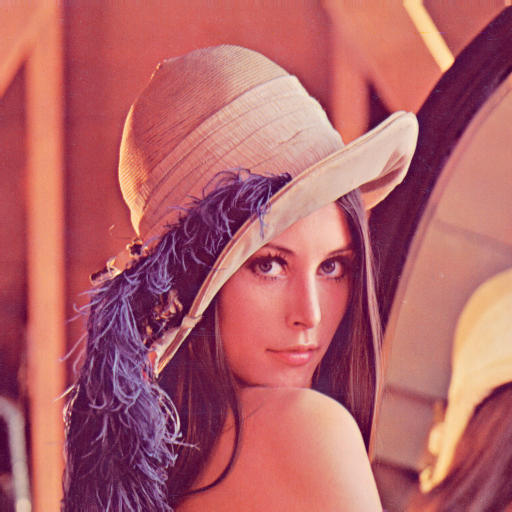

Buffer out before receive from DMA


In [52]:
print('Buffer in before receive from DMA')

in_buffer[0:largura*altura*3] = input_array
buf_image = Image.fromarray(in_buffer)

display(buf_image)

    
print('Buffer out before receive from DMA')

In [53]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer) 
    
    #pipe v2
    #registers.write(0, 1)
    
    #pipe v3
    registers.write(8,1) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [54]:
registers.write(0, largura)
registers.write(4, altura)
#registers.write(8, 0)

In [55]:
print(registers.read(0))
print(registers.read(4))
print(registers.read(8))

512
512
0


In [56]:
# Trigger the DMA transfer and wait for the result
import time


############
run_kernel()

start_time = time.time()
dma.sendchannel.wait()
dma.recvchannel.wait()
###########
stop_time = time.time()

Hardware output:  0.0007405281066894531


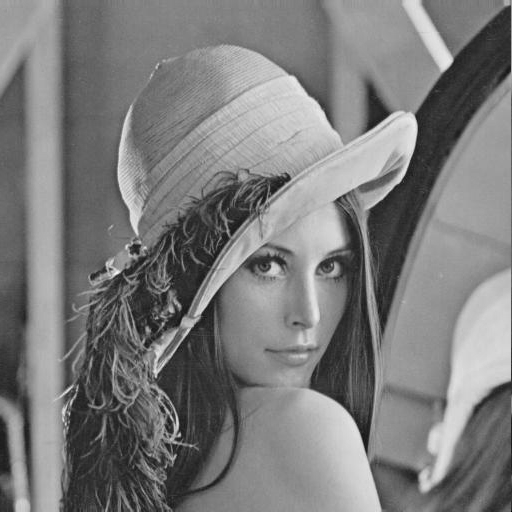

In [57]:
hw_exec_time = stop_time-start_time
print('Hardware output: ',hw_exec_time)


NovaIgagem = Image.new('RGB', (largura, altura))
#setarPixel = NovaIgagem.load()

result = Image.fromarray(out_buffer)
display(result)

# Free the buffers
in_buffer.close()
out_buffer.close()

NovaIgagem = result
NovaIgagem.save('./images/LenaCinza.jpg')

In [58]:
%%timeit
run_kernel()
resized_image = Image.fromarray(out_buffer)

100 loops, best of 3: 4.52 ms per loop


In [59]:
del in_buffer
del out_buffer